```{contents}
```
## Barrier

A **Barrier** in LangGraph is a **synchronization mechanism** that forces multiple parallel execution paths to **wait until all required branches complete** before allowing the graph to continue.
It enables **correct coordination of concurrent agents, tools, and computations** in complex workflows.

---

### **1. Motivation**

Modern LLM systems frequently execute tasks in **parallel**:

* Multiple agents working simultaneously
* Parallel tool calls
* Distributed data collection
* Independent model evaluations

However, many downstream operations require **all results** to be available before proceeding.

A **barrier** enforces this coordination.

---

### **2. Conceptual Model**

```
        ┌───── Task A ─────┐
        │                  │
Start ──┤───── Task B ─────┼───► Barrier ───► Next Stage
        │                  │
        └───── Task C ─────┘
```

All tasks **A, B, C** must complete before the barrier opens.

---

### **3. Formal Definition**

> A **Barrier** is a control-flow structure that blocks graph execution until **a specified set of parallel branches have all completed** and their state updates have been merged.

---

### **4. How LangGraph Implements Barriers**

LangGraph does not expose a class called `Barrier`.
Instead, barriers are constructed using:

* **Parallel branches (fan-out)**
* **Join nodes (fan-in)**
* **State reducers**

The **join node** functions as the barrier.

---

### **5. Building a Barrier — Example**

### **State Definition**

```python
class State(TypedDict):
    a: str
    b: str
    c: str
    final: str
```

### **Parallel Tasks**

```python
def task_a(state): return {"a": "Result A"}
def task_b(state): return {"b": "Result B"}
def task_c(state): return {"c": "Result C"}
```

### **Barrier (Join Node)**

```python
def join(state):
    return {"final": f"{state['a']} | {state['b']} | {state['c']}"}
```

### **Graph Construction**

```python
builder = StateGraph(State)

builder.add_node("A", task_a)
builder.add_node("B", task_b)
builder.add_node("C", task_c)
builder.add_node("JOIN", join)

builder.set_entry_point("A")
builder.add_edge("A", "B")
builder.add_edge("A", "C")

builder.add_edge("B", "JOIN")
builder.add_edge("C", "JOIN")
```

The `JOIN` node executes **only after both B and C complete** — this is the **barrier**.

---

### **6. Barrier With Agents**

Used in **multi-agent systems**:

```
Supervisor
   ├── Research Agent ─┐
   ├── Compute Agent ──┼──► Barrier ► Decision Agent
   └── Verify Agent ───┘
```

Guarantees the decision agent receives **complete context**.

---

### **7. Production Use Cases**

| Use Case              | Why Barrier           |
| --------------------- | --------------------- |
| Multi-agent reasoning | Collect all opinions  |
| Parallel tool calls   | Wait for all tools    |
| Map-Reduce workflows  | Reduce after map      |
| Distributed retrieval | Aggregate all docs    |
| Ensemble inference    | Combine model outputs |

---

### **8. Barrier vs No Barrier**

| Without Barrier    | With Barrier            |
| ------------------ | ----------------------- |
| Race conditions    | Deterministic execution |
| Incomplete context | Full context            |
| Unstable outputs   | Reliable outputs        |

---

### **9. Failure Handling with Barriers**

Production systems add:

* Timeout protection
* Retry policies
* Partial-failure handling
* Dead-path detection

---

### **10. Mental Model**

A LangGraph barrier is equivalent to:

> **Concurrency synchronization point in distributed systems**

It transforms parallel chaos into **deterministic coordination**.


### Demonstration

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, END

# -----------------------------
# 1. Shared State Definition
# -----------------------------
class State(TypedDict):
    a: str
    b: str
    c: str
    final: str

# -----------------------------
# 2. Parallel Tasks
# -----------------------------
def task_a(state):
    return {"a": "Result A"}

def task_b(state):
    return {"b": "Result B"}

def task_c(state):
    return {"c": "Result C"}

# -----------------------------
# 3. Barrier (Join Node)
# -----------------------------
def join(state):
    return {"final": f"{state['a']} | {state['b']} | {state['c']}"}

# -----------------------------
# 4. Build Graph
# -----------------------------
builder = StateGraph(State)

builder.add_node("A", task_a)
builder.add_node("B", task_b)
builder.add_node("C", task_c)
builder.add_node("JOIN", join)

builder.set_entry_point("A")

# Fan-out
builder.add_edge("A", "B")
builder.add_edge("A", "C")

# Barrier (fan-in)
builder.add_edge("B", "JOIN")
builder.add_edge("C", "JOIN")

builder.add_edge("JOIN", END)

graph = builder.compile()

# -----------------------------
# 5. Execute
# -----------------------------
result = graph.invoke({})
print(result)


{'a': 'Result A', 'b': 'Result B', 'c': 'Result C', 'final': 'Result A | Result B | Result C'}


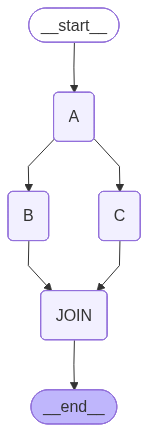

In [2]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())